# 3. Advanced Customization

The core principle of `TriPoDPy` is that we can change anything easily. Not only the initial conditions as shown in the previous chapter, but also the physics behind the simulation.

In [3]:
from tripod import Simulation

In [4]:
sim = Simulation()

## Customizing the Grids

By default, the radial and the mass grid will be created when calling `Simulation.initialize()`. However, there can be situations where one needs to know the grid sizes before completely initializing the Simulation object. For example, if we want to create custom fields and need to initialize them with the correct shape.

In that case, we can call `Simulation.makegrids()` to only create the grids without initializing the simulation objects. In fact, `Simulation.makegrids()` is by default called within `Simulation.initialize()`.

In [5]:
sim.grid

Group (Grid quantities)
-----------------------
    A            : NoneType
    Nr           : NoneType
    OmegaK       : NoneType
    r            : NoneType
    ri           : NoneType
  -----

In [6]:
sim.makegrids()

In [7]:
sim.grid

Group (Grid quantities)
-----------------------
    A            : Field (Radial grid annulus area [cm²]), constant
    Nr           : Field (# of radial grid cells), constant
    r            : Field (Radial grid cell centers [cm]), constant
    ri           : Field (Radial grid cell interfaces [cm]), constant
  -----
    OmegaK       : NoneType
  -----

**Note:** The Keplerian frequency has not been initialized at this point.

### The Radial Grid

By default the radial grid is a regular logarithmic grid, i.e. the ratio of adjacent grid cells is constant.

In [8]:
sim.grid.r[1:]/sim.grid.r[:-1]

[1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931
 1.07151931 1.07151931 1.07151931 1.07151931 1.07151931 1.0715

As explained in the previous chapter, the location of the grid boundaries and the number of grid cells can be controlled via `Simulation.ini.grid.rmin`, `Simulation.ini.grid.rmax`, and `Simulation.ini.grid.Nr`.  
`Simulation.makegrids()` will use these parameters to create the radial grid.

But it is also possible to completely customize the radial grid. To do so, we have to set the locations of the radial grid cell interfaces `Simulation.grid.ri` before calling either `Simulation.makegrids()` or `Simulation.initialize()`.

In this example, we simply want to refine the grid at a given location. We use this helper function, which takes an existing grid `ri` and  doubles the number of grid cells in a region `num` grid cells on both sides around location `r0`. We also recursively call this function with reduced `num` to even further refine the grid and to have a smooth transition between the high and low resolution regions.

In [9]:
import numpy as np

def refinegrid(ri, r0, num=3):
    """Function to refine the radial grid
    
    Parameters
    ----------
    ri : array
        Radial grid
    r0 : float
        Radial location around which grid should be refined
    num : int, option, default : 3
        Number of refinement iterations
        
    Returns
    -------
    ri : array
        New refined radial grid"""
    if num == 0:
        return ri
    ind = np.argmin(r0 > ri) - 1
    indl = ind-num
    indr = ind+num+1
    ril = ri[:indl]
    rir = ri[indr:]
    N = (2*num+1)*2
    rim = np.empty(N)
    for i in range(0, N, 2):
        j = ind-num+int(i/2)
        rim[i] = ri[j]
        rim[i+1] = 0.5*(ri[j]+ri[j+1])
    ri = np.concatenate((ril, rim, rir))
    return refinegrid(ri, r0, num=num-1)

We now create a regular logarithmic grid and feed it to our function. We want to refine the grid in a location around $4.5\,\mathrm{AU}$.

In [10]:
import dustpy.constants as c

In [11]:
ri = np.logspace(0., 3., num=100, base=10.) * c.au

In [12]:
ri = refinegrid(ri, 4.5*c.au, num=3)

We can now create a new empty Simulation object, assign the grid cell interfaces and initialize the grids.

In [13]:
sim = Simulation()

In [14]:
sim.grid.ri = ri

In [15]:
sim.grid

Group (Grid quantities)
-----------------------
    A            : NoneType
    Nr           : NoneType
    OmegaK       : NoneType
    r            : NoneType
    ri           : ndarray
  -----

**Note:** It is sufficient to assign a `numpy.ndarray` to `Simulation.grid.ri` and not a `simframe.Field`.

We can now make the grids.

In [16]:
sim.makegrids()

In [17]:
sim.grid

Group (Grid quantities)
-----------------------
    A            : Field (Radial grid annulus area [cm²]), constant
    Nr           : Field (# of radial grid cells), constant
    r            : Field (Radial grid cell centers [cm]), constant
    ri           : Field (Radial grid cell interfaces [cm]), constant
  -----
    OmegaK       : NoneType
  -----

As we can see, `Simulation.grid.ri` was automatically converted to a `simframe.Field` and the other fields were created. The number of radial grid cells is greater than $100$ as we added more grid cells.

In [18]:
sim.grid.Nr

114

To see that we actually refined the grid at the correct location, we can plot the location of the radial grid cells.

In [19]:
import matplotlib.pyplot as plt

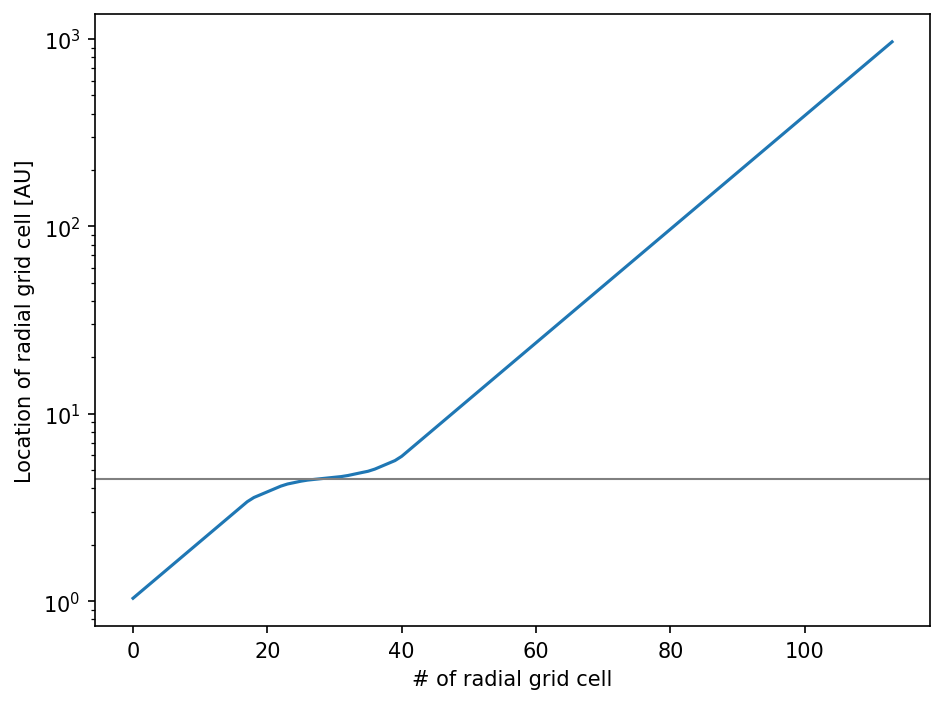

In [20]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.semilogy(sim.grid.r/c.au)
ax.axhline(4.5, c="gray", lw=1)
ax.set_xlabel("# of radial grid cell")
ax.set_ylabel("Location of radial grid cell [AU]")
fig.tight_layout()
plt.show()

The position of the radial grid cells have to be exactly in the center between their grid cell interfaces and are automatically calculated by `Simulation.makegrids()`.

In [21]:
sim.grid.r == 0.5 * (sim.grid.ri[1:] + sim.grid.ri[:-1])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]

## Customizing the Physics of a Field

In this example, we want to have a fragmentation velocity that depends on the temperature in the disk. If the temperature is below 150 K, we want to have a fragmentation velocity in the amount of 10 m/s, otherwise it shall be 1 m/s. The idea behind this approach is that particles coated in water ice are stickier than pure silicate particles and can consequently withstand higher collision velocities (see e.g. [Pinilla et al. (2017)](https://doi.org/10.3847/1538-4357/aa7edb)). Keep in mind, however, that newer experiments suggest that particles covered in water ice do not have a beneficial collisional behavior (see e.g. [Musiolik & Wurm (2019)](https://doi.org/10.3847/1538-4357/ab0428)).

First, we initialize our simulation object.

In [22]:
sim.initialize()

In [23]:
sim.dust.v.updater

Heartbeat
---------

Systole:  None
Updater:  list_updater
Diastole: None

Docstrings
----------

Systole:
The type of the None singleton.

Updater:
The attributes in this group are updated in the order: 
['frag', 'driftmax', 'rel'].

Diastole:
The type of the None singleton.

The fragmentation velocity is of shape `(Nr,)`, i.e. there is one value at every location in the grid.

In [24]:
sim.dust.v.frag.shape

(114,)

At the moment it is constant.

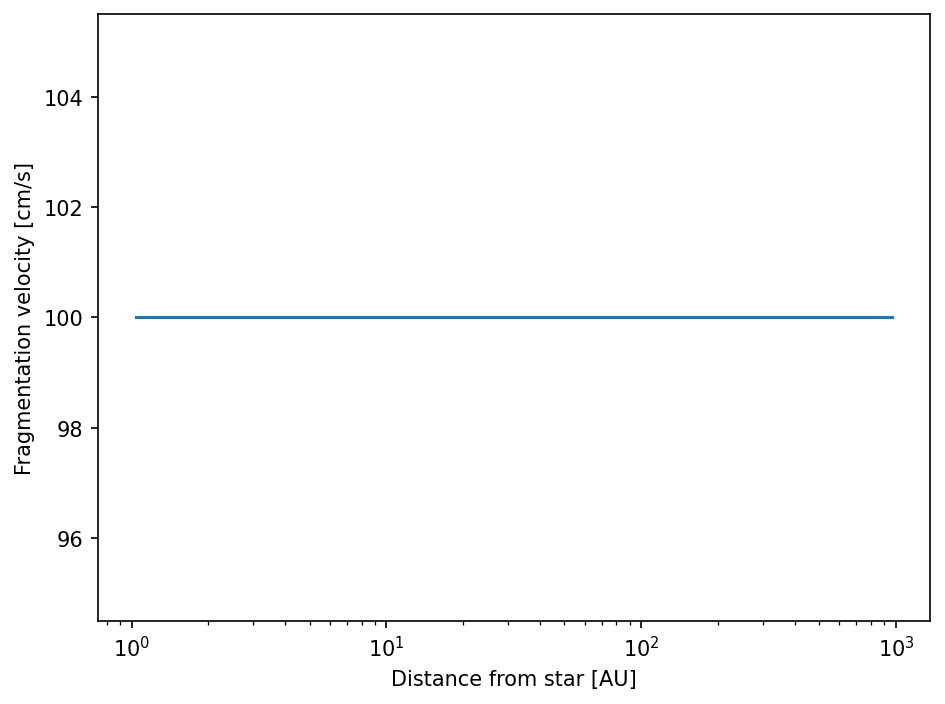

In [25]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.semilogx(sim.grid.r/c.au, sim.dust.v.frag)
ax.set_xlabel("Distance from star [AU]")
ax.set_ylabel("Fragmentation velocity [cm/s]")
fig.tight_layout()
plt.show()

We have to write a function that takes the simulation object as input parameter and returns our desired fragmentation velocities. To this end, we can use the fact that the gas temperature has the same shape. Keep in mind that everything has to be in cgs units.

In [26]:
sim.gas.T.shape

(114,)

In [27]:
def v_frag(sim):
    return np.where(sim.gas.T<150., 1000., 100)

We can now assign this function to the updater of the dust fragmentation velocities. For details of this process, please have a look at the [Simframe documentation](https://simframe.rtfd.io).

In [28]:
sim.dust.v.frag.updater = v_frag

The updater of a group/field stores a `simframe.Heartbeat` object. When calling the `update()` function, the heartbeat which consists of a `systole`, the actual `updater`, and a `diastole` will be executed. The `systole` is executed before the actual update functions, the `diastole` afterwards.

When assigning a function (or `None`) to the updater of a group/field, a new `Heartbeat` object will be created with empty systoles and diastoles only executing the update function. If the existing updater already has systoles/diastoles, those would be overwritten with an empty function.

To prevent this, we can directly assign the function only to the updater leaving the systoles/diastoles as they are.

The systoles/diastoles can be set with the following command. (Only for demonstration here, since we assign `None`. Read more about this in the section about systoles and diastoles.)

In [29]:
sim.dust.v.updater.systole = None
sim.dust.v.updater.diastole = None

As of now, the simulation object still holds the old data for the fragmentation velocity and needs to be instructed to update itself. We can either update the whole simulation frame with `Simulation.update()`, or we merely update the fragmentation velocities.

In [30]:
sim.dust.v.frag.update()

The fragmentation velocities should now show our desired behavior.

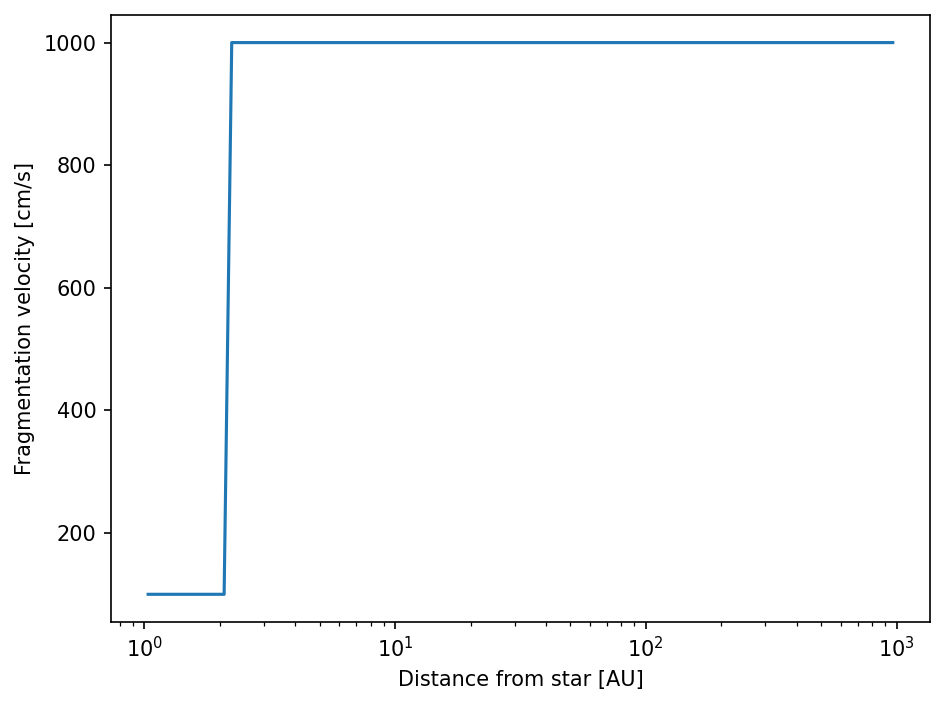

In [31]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.semilogx(sim.grid.r/c.au, sim.dust.v.frag)
ax.set_xlabel("Distance from star [AU]")
ax.set_ylabel("Fragmentation velocity [cm/s]")
fig.tight_layout()
plt.show()

**Note:** Upon customizing a quantity on which other quantities depend, one also has to update these quantities. In our case, this would be the sticking/fragmentation probabilites. Therefore, it is always better to update the entire simulation frame.

In [32]:
sim.update()

## Adding Custom Fields

We can not only modify existing fields, we can also create our own fields.

In this example, we want to add another field `rsnow` to `Simulation.grid` that gives us the location of the so called snowline, i.e. the location in the disk where water ice starts to sublime.

First, we add the field and initialize it with zero.

In [33]:
sim.grid.addfield("rsnow", 0., description="Snowline location [cm]")

0.0

The grid group now has a new member.

In [34]:
sim.grid

Group (Grid quantities)
-----------------------
    A            : Field (Radial grid annulus area [cm²]), constant
    Nr           : Field (# of radial grid cells), constant
    OmegaK       : Field (Keplerian frequency [1/s])
    r            : Field (Radial grid cell centers [cm]), constant
    ri           : Field (Radial grid cell interfaces [cm]), constant
    rsnow        : Field (Snowline location [cm])
  -----

As a next step, we have to write a function that returns us the location of the snowline. Here, we simply use the first grid cell where the temperature is smaller than $150\,\mathrm{K}$ and return the value of the inner interface of that grid cell.

In [35]:
def rsnow(sim):
    isnow = np.argmax(sim.gas.T<150.)
    return sim.grid.ri[isnow]

We assign this function to the updater of our snowline field.

In [36]:
sim.grid.rsnow.updater.updater = rsnow

And update the field.

In [37]:
sim.grid.rsnow.update()

In [38]:
print("The snowline is located at {:4.2f} AU.".format(sim.grid.rsnow/c.au))

The snowline is located at 2.15 AU.


Right now, the temperature is constant throughout the simulation, because the stellar parameters do not change. To see an effect in our snowline location, we need to have a changing temperature profile.

To achieve this, we let the stellar radius decrease from a value of $3\,M_\odot$ to $2\,M_\odot$ within the first $10,000\,\mathrm{yrs}$. As a consequence, the disk temperature decreases. This is only for demonstration purposes and is not necessarily physical.

In [39]:
def Rstar(sim):
    dR = -1.*c.R_sun
    dt = 1.e4 * c.year
    m = dR/dt
    R = m*sim.t + 3.*c.R_sun
    R = np.maximum(R, c.R_sun)
    return R

And assign this to the updater of the stellar radius.

In [40]:
sim.star.R.updater.updater = Rstar

## Modifying the Update Order

But we are still not done, yet. We have given `TwoPopPy` instructions how to update the snowline location, but we have not yet told it to actually update it regularily.

`TwoPopPy` calls `Simulation.update()`, the updater of the simulation object, once per timestep after the integration step and just before writing the data files. The updater of a group/field is basically a list of groups/fields, whose updater is called in that order.

For the main simulation object this is

In [41]:
sim.updateorder

['star', 'grid', 'components', 'gas', 'dust']

This means that if we call `Simulation.update()`, we basically call `Simulation.star.update()`, `Simulation.grid.update()`, `Simulation.gas.update()`, and `Simulation.dust.update()` in that order.

The updaters of the sub-groups and fields look as follows

In [42]:
sim.grid.updateorder

['OmegaK']

In [43]:
sim.gas.updateorder

['Sigma',
 'mu',
 'T',
 'alpha',
 'cs',
 'Hp',
 'nu',
 'rho',
 'n',
 'mfp',
 'P',
 'eta',
 'torque',
 'S']

In [44]:
sim.gas.S.updateorder

['ext', 'tot']

In [45]:
sim.gas.v.updateorder

['visc', 'rad']

In [46]:
sim.dust.updateorder

['delta',
 'rhos',
 'fill',
 'backreaction',
 'f',
 'qrec',
 'a',
 'm',
 'St',
 'H',
 'rho',
 'D',
 'eps',
 'v',
 'p',
 'q',
 'SigmaFloor',
 'S']

In [47]:
sim.dust.backreaction.updateorder

['A', 'B']

In [48]:
sim.dust.delta.updateorder

['rad', 'turb', 'vert']

In [49]:
sim.dust.Fi.updateorder

['adv', 'diff', 'tot']

In [50]:
sim.dust.p.updateorder

['frag', 'stick', 'fragtrans', 'driftfrag']

In [51]:
sim.dust.S.updateorder

['compo', 'ext', 'tot', 'smax_hyd']

In [52]:
sim.dust.v.updateorder

['frag', 'driftmax', 'rel']

In [53]:
sim.dust.v.rel.updateorder

['azi', 'brown', 'rad', 'turb', 'vert', 'tot']

**Note:** The gas updater does not contain the updaters of `Simulation.gas.v` and `Simulation.gas.Fi` and the updater of the gas sources does not contain the updater of `Simulation.gas.S.hyd`. These are quantities that are calculated in the finalization step of the integrator, since they are derived from the result of the implicit gas integration.

The same is true for `Simulation.dust.v.rad`, `Simulation.dust.Fi`, and `Simulation.dust.S.hyd` in the dust updater, which are also calculated from the implicit integration in the finalization step of the integrator

As we can see, the grid updater is only updating the Keplerian frequency, but not our snowline location. So we can simply add it to the list.

In [54]:
sim.grid.updater = ["OmegaK", "rsnow"]

If we assign lists to updaters, their systoles and diastoles will always be overwritten with `None`.

In [55]:
sim.grid.updateorder

['OmegaK', 'rsnow']

## Systoles and Diastoles

However, the previous solution has a conceptional problem. As we previously saw from the update order the grid is updated before the gas. The snowline location, however, needs the gas temperature and, therefore, has to be updated after the gas. On the other hand, we also cannot update the grid as a whole after the gas, because the gas updaters need the Keplerian frequency. We need another solution.

But first, we revert the grid updater.

In [56]:
sim.grid.updater = ["OmegaK"]

Every updater has a systole and a diastole. These are functions that are called before and after the actual updater respectively. Since no other quantity depends on our snowline location, we can simply update it at the end and put it in the diastole of the main updater. Alternatively, we could assign it to the diastole of the gas temperature updater, since it only requires the updated gas temperature.

We therefore write a diastole function that is updating the snowline location separately.

In [57]:
def diastole(sim):
    sim.grid.rsnow.update()

We then assign this function to the diastole of the gas temperature updater.

In [58]:
sim.gas.T.updater.diastole = diastole

Now every time `Simulation.gas.T.update()` is called, `Simulation.grid.rsnow.update()` will be called at the end of it.

## Customizing the Snapshots

As has been already explained in a previous chapter, the snapshots can be customized by simply setting `Simulation.t.snapshots`. In this example, we only want to run the simulation for $10,000\,\mathrm{yrs}$.

In [59]:
sim.t.snapshots = np.logspace(3., 4., num=21, base=10.) * c.year

We can now change the data directory to avoid an overwrite error and start the simulation with our modifications.

In [60]:
sim.writer.datadir = "3_data"
sim.writer.overwrite = True

In [61]:
sim.run()


TriPoD v0.0.1

Creating data directory 3_data.
Writing file 3_data/data0000.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0001.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0002.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0003.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0004.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0005.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0006.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0007.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0008.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0009.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0010.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0011.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0012.hdf5
Writing dump file 3_data/frame.dmp
Writing file 3_data/data0013.hdf5
Writing dump file 3_d

We can now have a look at the result of our modifications.

In [62]:
from tripod import plot

In [63]:
sim.dust.v.rel.tot[:,-2,-1]

[9.89658712e+01 9.99795543e+01 9.99931283e+01 9.99882033e+01
 9.99843676e+01 9.99809756e+01 9.99772033e+01 9.99783045e+01
 1.00092303e+02 1.02550603e+02 1.62434565e+02 9.93905198e+02
 9.98985789e+02 9.98498631e+02 9.97315060e+02 9.95905973e+02
 9.94579741e+02 9.94379062e+02 9.93139596e+02 9.91949367e+02
 9.91712111e+02 9.91319210e+02 9.91774847e+02 9.91037499e+02
 9.90148742e+02 9.90430109e+02 9.89982199e+02 9.89382173e+02
 9.89162393e+02 9.88935977e+02 9.88690497e+02 9.88024054e+02
 9.88175920e+02 9.88272083e+02 9.87810156e+02 9.86409661e+02
 9.86972695e+02 9.86802794e+02 9.85933036e+02 9.83055253e+02
 9.83943311e+02 9.83008881e+02 9.80859100e+02 9.78463449e+02
 9.75468673e+02 9.71421468e+02 9.65527750e+02 9.56393836e+02
 9.41678291e+02 9.17617083e+02 8.78413679e+02 8.15801207e+02
 7.19699202e+02 5.83890040e+02 4.26961121e+02 2.90092421e+02
 1.89872536e+02 1.21291110e+02 6.99200265e+01 3.05151179e+01
 8.22471166e+00 6.17436300e+00 4.80862603e+00 3.87977236e+00
 3.43749223e+00 2.906580

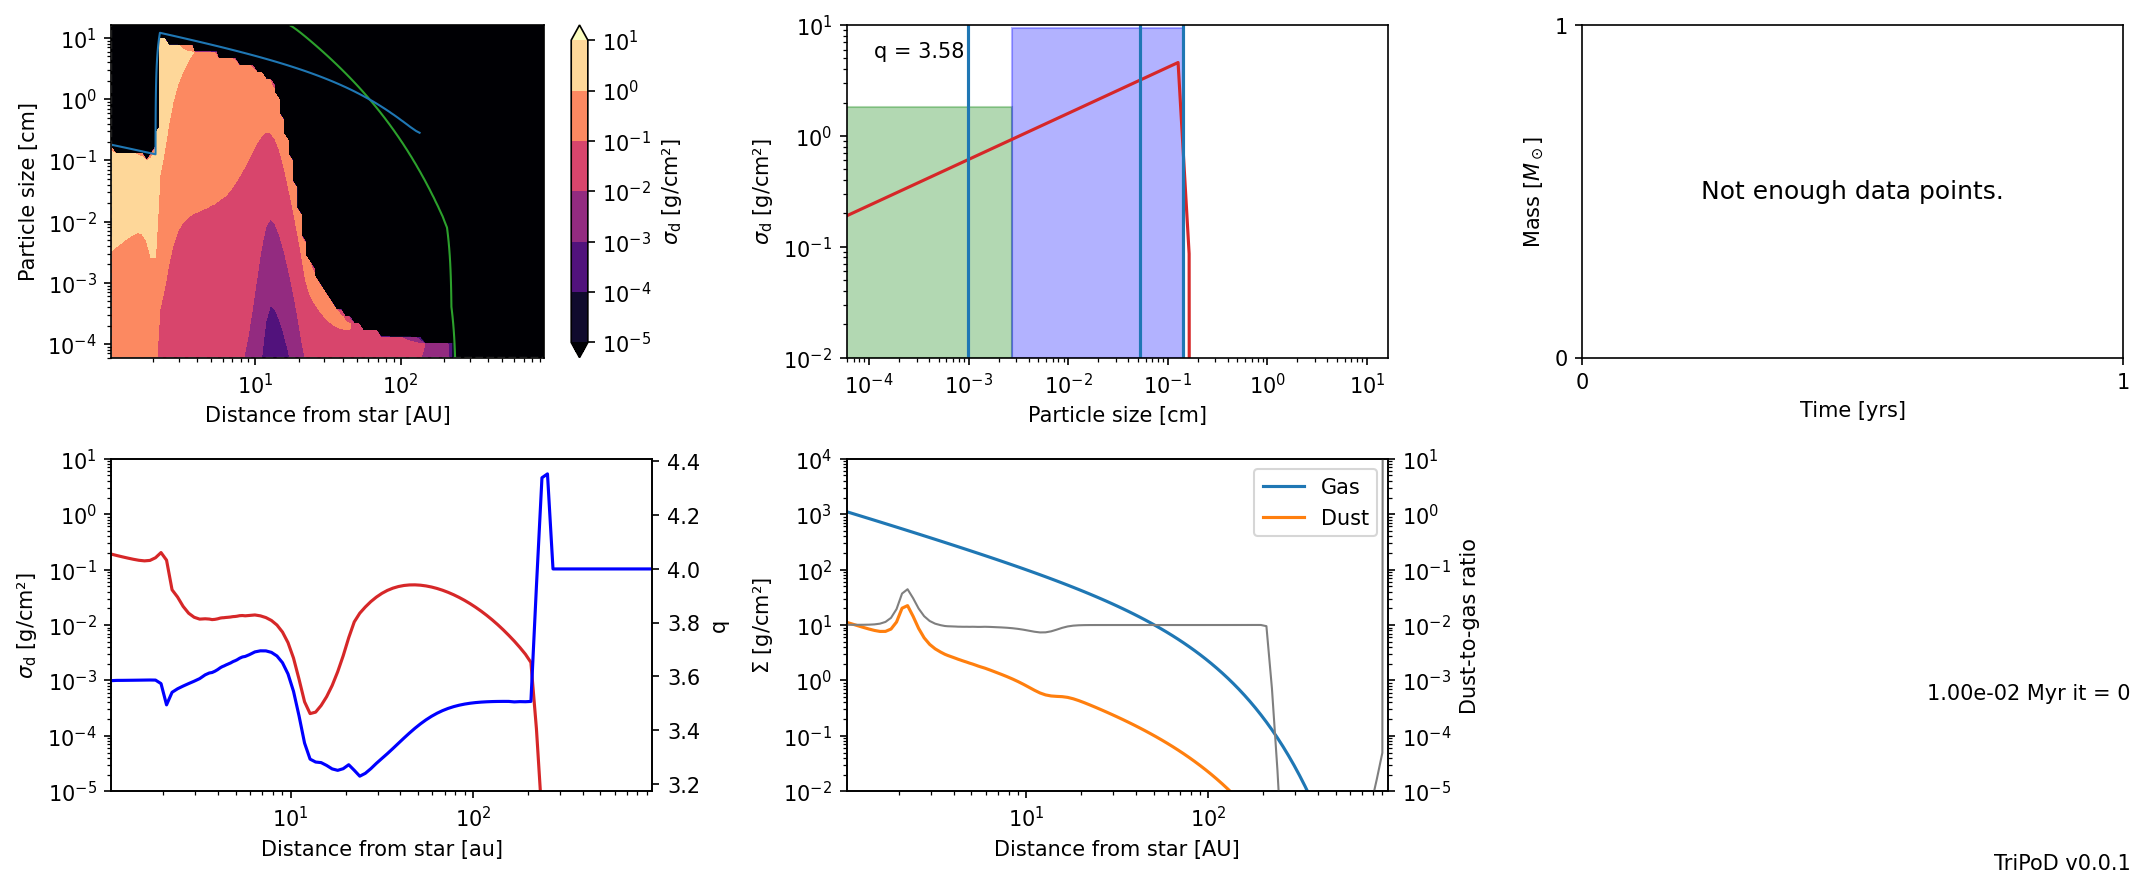

In [64]:
plot.panel(sim,show_limits=True)

The change in fragmentation velocity has an obvious effect on the particle sizes.

To check the time evolution of the snowline, we have to read the data. The gray lines are the positions of the radial grid cell interfaces and snapshots, which explains the discrete behavior of the snowline location.

In [65]:
t = sim.writer.read.sequence("t") / c.year
ri = sim.writer.read.sequence("grid.ri") / c.au
rsnow = sim.writer.read.sequence("grid.rsnow") / c.au

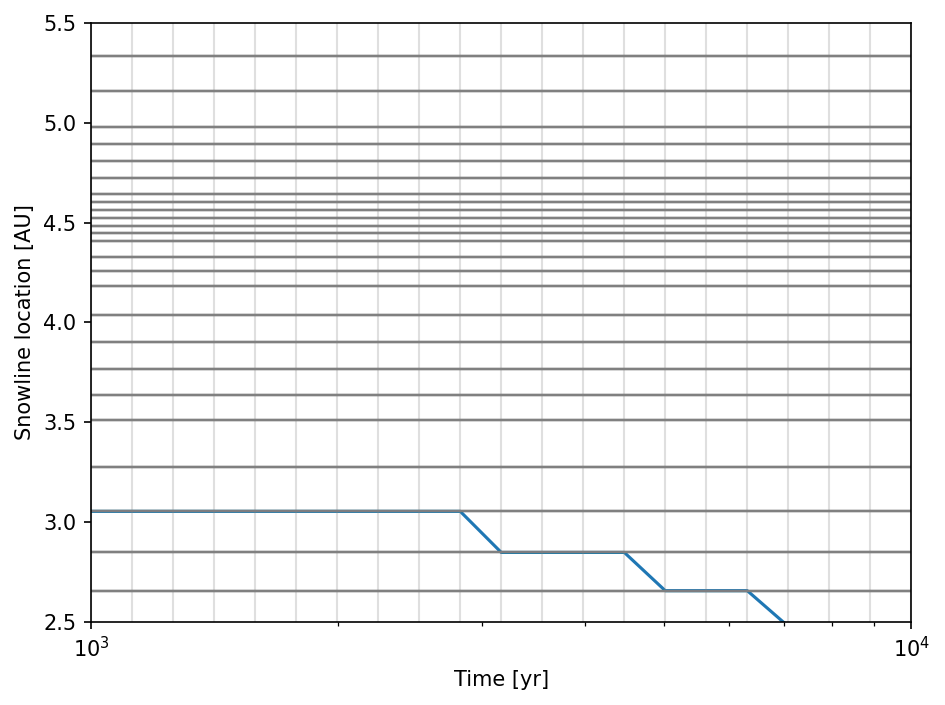

In [66]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.semilogx(t, rsnow)
ax.hlines(ri, 1.e3, 1e4, lw=1, color="gray", alpha=0.25)
ax.vlines(t, 2.5, 5.5, lw=1, color="gray", alpha=0.25)
ax.set_xlim(1.e3, 1.e4)
ax.set_ylim(2.5, 5.5)
ax.set_xlabel("Time [yr]")
ax.set_ylabel("Snowline location [AU]")
fig.tight_layout()
plt.show()